## Vision Transformer (ViT) architecture
Paper source: https://arxiv.org/abs/2010.11929

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Get setup, create datasets and dataloaders

In [ ]:
# Checking versions of libraries for google colab: torch, torchvision

try:
    import torch
    import torchvision
    print(f'torch version: {torch.__version__}')
    print(f'torchvision version: {torchvision.__version__}')
    assert int(torch.__version__.split('.')[1]) >= 12, 'torch version should be 1.12+'
    assert int(torchvision.__version__.split('.')[1]) >= 13, 'torchvision version should be 0.13+'
except:
    print(f'[INFO] torch/torchvision versions not as required, installing required versions.')



c:\Users\TimJimTangtong\Miniconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch version: 1.13.1
torchvision version: 0.14.1


In [ ]:
# Bunch of imports

import torch
from torch import nn

import torchvision
from torchvision import transforms

from torchinfo import summary
from torchmetrics import Accuracy

import matplotlib.pyplot as plt

from pathlib import Path
import random

import sys
sys.path.insert(0, '..')
from python_scripts import data_setup, engine, model_builder, utils
from python_scripts.helper_functions import download_data, plot_loss_curves

In [ ]:
# Checking GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [ ]:
# Constants and Hyper-parameters

BATCH_SIZE = 32
IMAGE_SIZE = 224

In [ ]:
# Create datasets and dataloaders

image_path = Path('../data/extracted/pizza_steak_sushi_20_percent/')
train_dir = image_path / 'train'
test_dir = image_path / 'test'

manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
print(f'Manually created transforms: {manual_transforms}')

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms,
    test_transform=manual_transforms,
    batch_size=BATCH_SIZE
)

print(f'Dataloaders created.\nlen(train_dataloader):{len(train_dataloader)},\nlen(test_dataloader): {len(test_dataloader)},\nclass_names: {class_names}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)
Dataloaders created.
len(train_dataloader):19,
len(test_dataloader): 7,
class_names: ['pizza', 'steak', 'sushi']


(-0.5, 223.5, 223.5, -0.5)

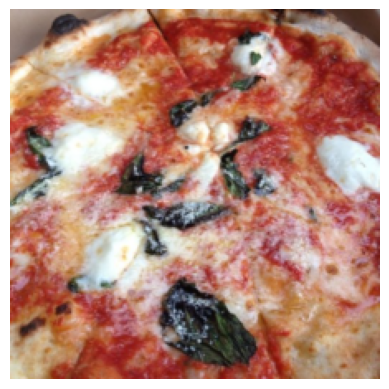

In [ ]:
images, labels = next(iter(train_dataloader))
rand_number = random.randint(0, len(labels))
image = images[rand_number]
label = labels[rand_number]
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)


## Eq.1
$$
\begin{aligned}
\mathbf{z}_{0} & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\end{aligned}
$$

**pseudo code**
```
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] +
[class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

In [ ]:
# Split data into patches, and creating the class, position and patch embedding

height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int(height * width / patch_size ** 2)

embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape}')

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


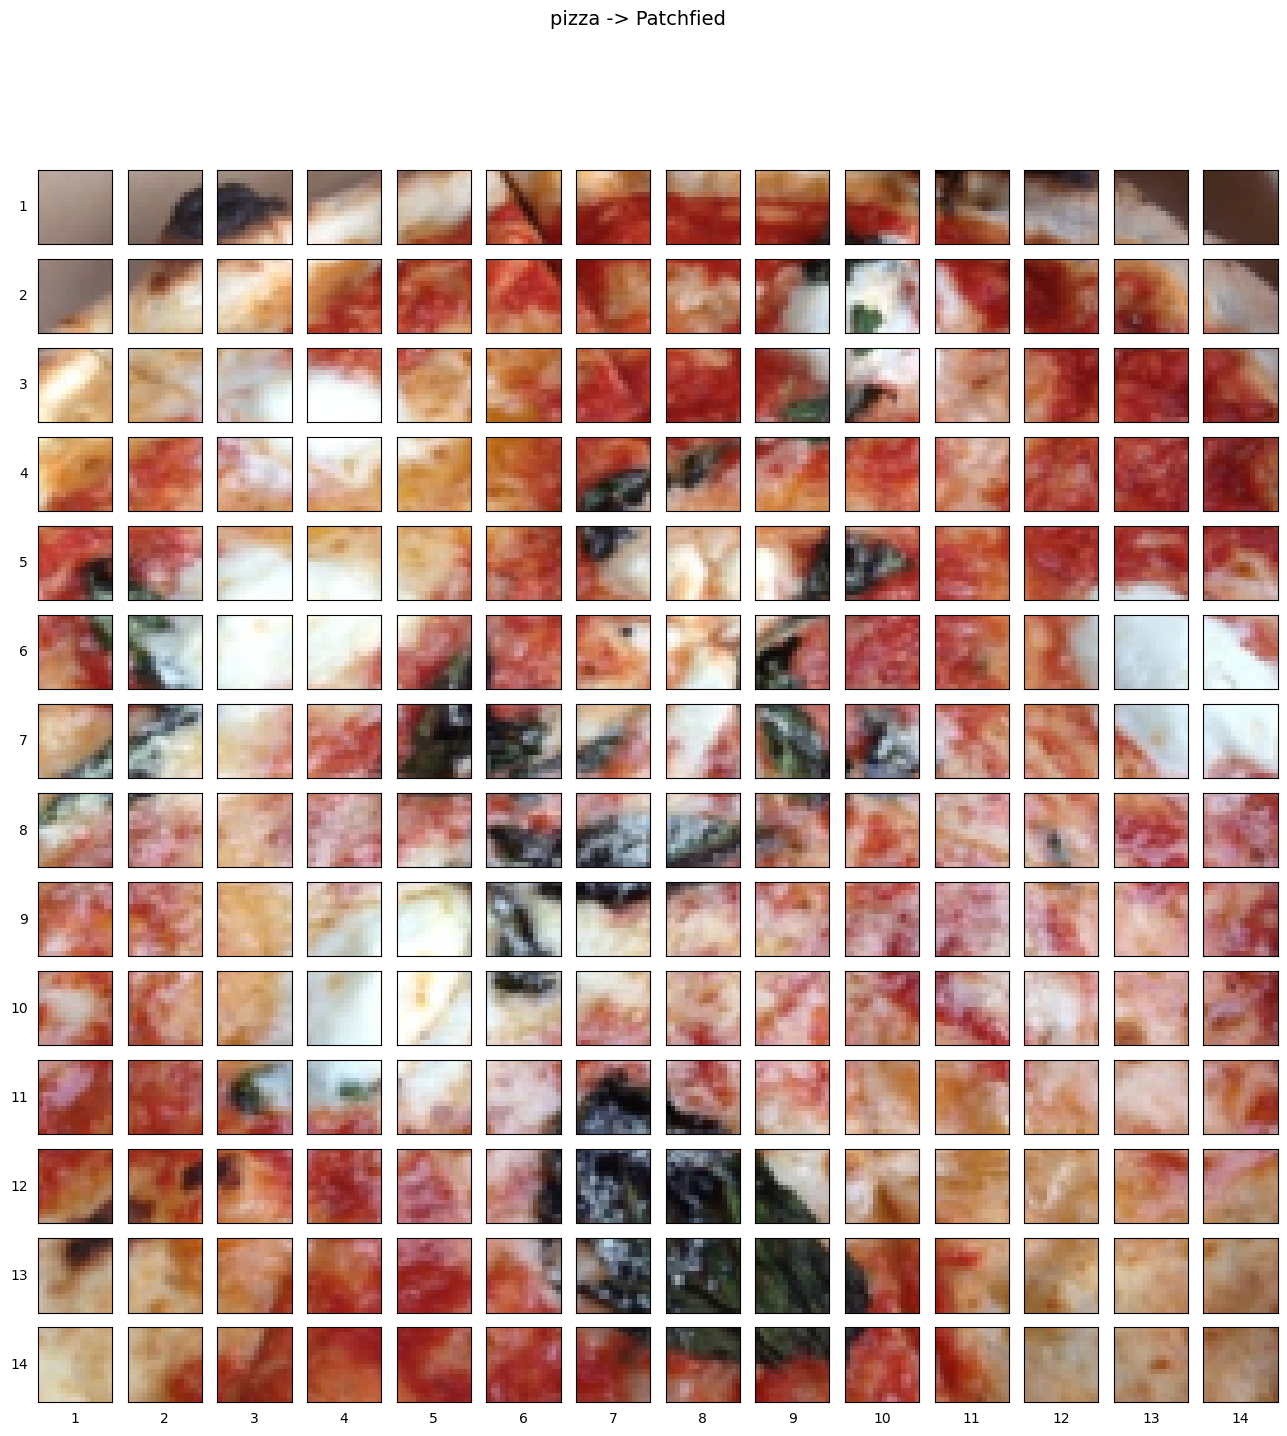

In [ ]:
img_size = 224
patch_size = 16
n_patches = img_size // patch_size

fig, axs = plt.subplots(
    nrows=n_patches,
    ncols=n_patches,
    sharex=True,
    sharey=True,
    figsize=(patch_size, patch_size)
)

for i, ipatch in enumerate(range(0, img_size, patch_size)):
    for j, jpatch in enumerate(range(0, img_size, patch_size)):
        axs[i][j].imshow(image.permute(1, 2, 0)[ipatch:ipatch+patch_size, jpatch:jpatch+patch_size, :])
        axs[i][j].set_ylabel(
            i + 1,
            rotation='horizontal',
            horizontalalignment='right',
            verticalalignment='center'
        )
        axs[i][j].set_xlabel(j + 1)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].label_outer()

fig.suptitle(f'{class_names[label]} -> Patchfied', fontsize=14)
plt.show()

In [ ]:
# Create conv2d layer to turn image into patches of learnable feature maps

patch_size = 16

conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

image_out_of_conv = conv2d(image.unsqueeze(dim=0))

flatten_layer = nn.Flatten(
    start_dim=2,
    end_dim=3
)

image_out_of_flatten = flatten_layer(image_out_of_conv)
image_out_of_flatten_permuted = image_out_of_flatten.permute(0, 2, 1)

single_flatten_feature_map = image_out_of_flatten_permuted[:, :, 0]
print(single_flatten_feature_map.shape)
plt.imshow(single_flatten_feature_map.detach().numpy())
plt.axis(False)


torch.Size([1, 196])


(-0.5, 195.5, 0.5, -0.5)

In [ ]:
torch.manual_seed(42)

patchify = model_builder.PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

print(f'Input image size: {image.unsqueeze(dim=0).shape}')
patch_embedded_image = patchify(image.unsqueeze(dim=0))
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [ ]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(
    data=torch.ones(batch_size, 1, embedding_dimension),
    requires_grad=True
)

patch_embedded_image_with_class_embedding = torch.cat(
    tensors=[class_token, patch_embedded_image],
    dim=1
)

print(patch_embedded_image_with_class_embedding)
print(f'{patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token+number_of_patches, embedding_dim)')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5837,  0.1221, -0.1129,  ...,  0.4231, -0.3289,  0.2228],
         [-0.4154,  0.0734, -0.0314,  ...,  0.2278, -0.2212,  0.2399],
         ...,
         [-0.6765,  0.1363, -0.1221,  ...,  0.4095, -0.2713,  0.1958],
         [-0.6798,  0.1057, -0.1515,  ...,  0.3887, -0.3199,  0.2753],
         [-0.5408,  0.0950, -0.2163,  ...,  0.3834, -0.2537,  0.2194]]],
       grad_fn=<CatBackward0>)
torch.Size([1, 197, 768]) -> (batch_size, class_token+number_of_patches, embedding_dim)


In [ ]:
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True)
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding.shape)

torch.Size([1, 197, 768])


In [ ]:
# Putting all together for Equation 1

torch.manual_seed(42)

patch_size = 16

print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(dim=0)
print(f'Input image shape: {x.shape}')

patch_embedding_layer = model_builder.PatchEmbedding(
    in_channels=3,
    patch_size=patch_size,
    embedding_dim=768
)
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad=True
)
print(f'Class token embedding shape: {class_token.shape}')

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

number_of_patches = int(height * width / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension))

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Eq.2&3
$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

**pseudo code**
```
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
x_output_MLP_block = MPL_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

In [ ]:
msa_block = model_builder.MultiHeadSelfAttentionBlock(
    embedding_dim=768,
    num_heads=12,
    attn_dropout=0
)

mlp_block = model_builder.MultiLayerPerceptronBlock(
    embedding_dim=768,
    mlp_size=3072,
    dropout=0.1
)

patched_image_through_msa_block = msa_block(patch_and_position_embedding)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

print(patched_image_through_msa_block.shape)
print(patched_image_through_mlp_block.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [ ]:
torch.manual_seed(42)

transformer_encoder_block = model_builder.TransformerEncoderBlock()

summary(
    model=transformer_encoder_block,
    input_size=(1, 197, 768),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptronBlock (mlp_block)            [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_layer)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
torch.manual_seed(42)

torch_transformerencoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation='gelu',
    batch_first=True,
    norm_first=True,
)

summary(
    model=torch_transformerencoder_layer,
    input_size=(1, 197, 768),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Eq.4
$$
\begin{aligned}
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

### Replicated model info VS pretrained torchvision model info

In [ ]:
# Putting all together

torch.manual_seed(42)

vit = model_builder.ViT(
    num_classes=len(class_names)
)

print(vit(image.unsqueeze(dim=0)))

summary(
    model=vit,
    input_size=(1, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

tensor([[-0.0479,  0.8743,  0.6895]], grad_fn=<AddmmBackward0>)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [ ]:
pretrained_vit_weight = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weight)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(
    in_features=768,
    out_features=len(class_names)
)

summary(
    model=pretrained_vit,
    input_size=(1, 3, 224, 224),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)



Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Training comparison between models

In [ ]:
ViT_results = engine.train_tensorboard(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(
        params=vit.parameters(),
        lr=1e-3,
        betas=(0.9, 0.999),
        weight_decay=0.1
    ),
    accuracy_fn=Accuracy(task='multiclass', num_classes=len(class_names)),
    epochs=10,
    device=device,
    # writer=utils.create_writer( # A 6gb memory GPU seems not to afford writer
    #     experiment_name='Rep_ViT_paper',
    #     model_name='ViT_architecture'
    # )
)

ViT_results

 10%|█         | 1/10 [00:17<02:41, 17.91s/it]

Epoch: 0 | Train_loss: 2.7391, Train_acc: 0.3165 | Test_loss: 1.3529, Test_acc: 0.3810


 20%|██        | 2/10 [00:35<02:21, 17.68s/it]

Epoch: 1 | Train_loss: 1.3255, Train_acc: 0.2990 | Test_loss: 1.1142, Test_acc: 0.3810


 30%|███       | 3/10 [00:53<02:03, 17.66s/it]

Epoch: 2 | Train_loss: 1.1475, Train_acc: 0.3363 | Test_loss: 1.1361, Test_acc: 0.2738


 40%|████      | 4/10 [01:10<01:45, 17.63s/it]

Epoch: 3 | Train_loss: 1.1324, Train_acc: 0.3406 | Test_loss: 1.1567, Test_acc: 0.2738


 50%|█████     | 5/10 [01:28<01:28, 17.62s/it]

Epoch: 4 | Train_loss: 1.1329, Train_acc: 0.3136 | Test_loss: 1.0969, Test_acc: 0.3452


 60%|██████    | 6/10 [01:45<01:10, 17.62s/it]

Epoch: 5 | Train_loss: 1.1190, Train_acc: 0.2968 | Test_loss: 1.1019, Test_acc: 0.3810


 70%|███████   | 7/10 [02:03<00:52, 17.61s/it]

Epoch: 6 | Train_loss: 1.1171, Train_acc: 0.3260 | Test_loss: 1.1219, Test_acc: 0.3452


 80%|████████  | 8/10 [02:21<00:35, 17.62s/it]

Epoch: 7 | Train_loss: 1.1152, Train_acc: 0.3319 | Test_loss: 1.1100, Test_acc: 0.2738


 90%|█████████ | 9/10 [02:38<00:17, 17.60s/it]

Epoch: 8 | Train_loss: 1.1349, Train_acc: 0.2961 | Test_loss: 1.1548, Test_acc: 0.3452


100%|██████████| 10/10 [02:56<00:00, 17.63s/it]

Epoch: 9 | Train_loss: 1.1262, Train_acc: 0.3077 | Test_loss: 1.1036, Test_acc: 0.3452


{'train_loss': [array(2.7390938, dtype=float32),
  array(1.325503, dtype=float32),
  array(1.1474636, dtype=float32),
  array(1.1324133, dtype=float32),
  array(1.1328619, dtype=float32),
  array(1.1189617, dtype=float32),
  array(1.1171255, dtype=float32),
  array(1.1151868, dtype=float32),
  array(1.1349279, dtype=float32),
  array(1.126188, dtype=float32)],
 'train_acc': [array(0.31652045, dtype=float32),
  array(0.2989766, dtype=float32),
  array(0.3362573, dtype=float32),
  array(0.3406433, dtype=float32),
  array(0.3135965, dtype=float32),
  array(0.2967837, dtype=float32),
  array(0.3260234, dtype=float32),
  array(0.33187136, dtype=float32),
  array(0.29605266, dtype=float32),
  array(0.30774856, dtype=float32)],
 'test_loss': [array(1.3528864, dtype=float32),
  array(1.1141734, dtype=float32),
  array(1.136106, dtype=float32),
  array(1.1567168, dtype=float32),
  array(1.0968792, dtype=float32),
  array(1.1019439, dtype=float32),
  array(1.1218953, dtype=float32),
  array(1.10

In [ ]:
# torch.cuda.max_memory_allocated() / 1024 / 1024 / 1024

5.115738868713379

In [ ]:
pretrained_vit_transforms = pretrained_vit_weight.transforms()

train_dataloader_pretrained, test_dataloader_pretrained, _ = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=pretrained_vit_transforms,
    test_transform=pretrained_vit_transforms,
    batch_size=BATCH_SIZE
)

In [ ]:
pretrained_ViT_results = engine.train_tensorboard(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(
        params=pretrained_vit.parameters(),
        lr=1e-3,
        betas=(0.9, 0.999),
        weight_decay=0.1
    ),
    accuracy_fn=Accuracy(task='multiclass', num_classes=len(class_names)),
    epochs=10,
    device=device,
    # writer=utils.create_writer(
    #     experiment_name='Rep_ViT_paper',
    #     model_name='ViT_architecture',
    #     extra='pretrained_model'
    # )
)

pretrained_ViT_results

 10%|█         | 1/10 [00:10<01:31, 10.13s/it]

Epoch: 0 | Train_loss: 0.2332, Train_acc: 0.9474 | Test_loss: 0.1195, Test_acc: 0.9821


 20%|██        | 2/10 [00:19<01:19,  9.93s/it]

Epoch: 1 | Train_loss: 0.1378, Train_acc: 0.9620 | Test_loss: 0.0899, Test_acc: 0.9821


 30%|███       | 3/10 [00:29<01:08,  9.78s/it]

Epoch: 2 | Train_loss: 0.1035, Train_acc: 0.9693 | Test_loss: 0.0851, Test_acc: 0.9821


 40%|████      | 4/10 [00:39<00:58,  9.76s/it]

Epoch: 3 | Train_loss: 0.0835, Train_acc: 0.9803 | Test_loss: 0.0778, Test_acc: 0.9821


 50%|█████     | 5/10 [00:49<00:49,  9.82s/it]

Epoch: 4 | Train_loss: 0.0734, Train_acc: 0.9868 | Test_loss: 0.0777, Test_acc: 0.9821


 60%|██████    | 6/10 [00:59<00:39,  9.92s/it]

Epoch: 5 | Train_loss: 0.0691, Train_acc: 0.9920 | Test_loss: 0.0722, Test_acc: 0.9881


 70%|███████   | 7/10 [01:09<00:30, 10.03s/it]

Epoch: 6 | Train_loss: 0.0619, Train_acc: 0.9934 | Test_loss: 0.0805, Test_acc: 0.9821


 80%|████████  | 8/10 [01:19<00:20, 10.02s/it]

Epoch: 7 | Train_loss: 0.0574, Train_acc: 1.0000 | Test_loss: 0.0715, Test_acc: 0.9821


 90%|█████████ | 9/10 [01:29<00:09,  9.96s/it]

Epoch: 8 | Train_loss: 0.0556, Train_acc: 0.9956 | Test_loss: 0.0711, Test_acc: 0.9821


100%|██████████| 10/10 [01:39<00:00,  9.90s/it]

Epoch: 9 | Train_loss: 0.0548, Train_acc: 0.9956 | Test_loss: 0.0695, Test_acc: 0.9821


{'train_loss': [array(0.23324607, dtype=float32),
  array(0.1377649, dtype=float32),
  array(0.10346998, dtype=float32),
  array(0.08353583, dtype=float32),
  array(0.07336999, dtype=float32),
  array(0.06906752, dtype=float32),
  array(0.06185476, dtype=float32),
  array(0.05737598, dtype=float32),
  array(0.0555546, dtype=float32),
  array(0.05480191, dtype=float32)],
 'train_acc': [array(0.94736844, dtype=float32),
  array(0.9619883, dtype=float32),
  array(0.9692982, dtype=float32),
  array(0.9802632, dtype=float32),
  array(0.986842, dtype=float32),
  array(0.99195904, dtype=float32),
  array(0.9934211, dtype=float32),
  array(1., dtype=float32),
  array(0.995614, dtype=float32),
  array(0.9956141, dtype=float32)],
 'test_loss': [array(0.11948056, dtype=float32),
  array(0.0899436, dtype=float32),
  array(0.08507223, dtype=float32),
  array(0.07775539, dtype=float32),
  array(0.0777363, dtype=float32),
  array(0.07224593, dtype=float32),
  array(0.08047261, dtype=float32),
  array

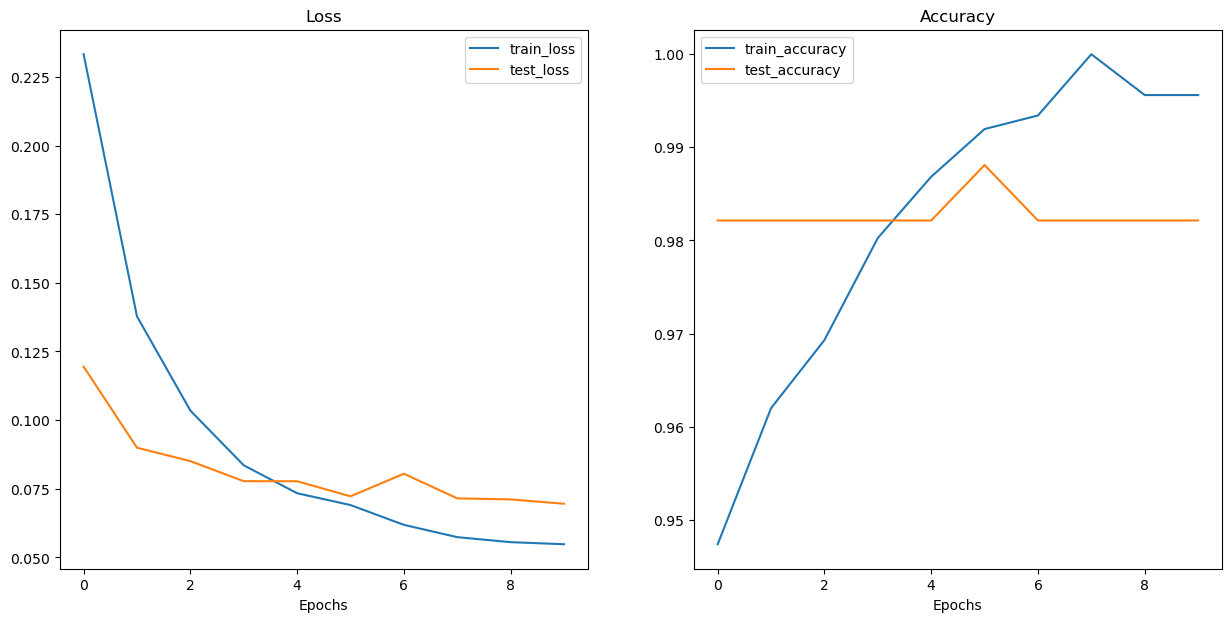

In [ ]:
plot_loss_curves(pretrained_ViT_results)

In [ ]:
utils.save_model(
    model=pretrained_vit,
    target_dir='../models',
    model_name='pretrained_vit_feature_extractor_pizza_steak_sushi.pth'
)

pretrained_vit_model_size = Path('../models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth').stat().st_size // (1024*1024)
print(f'Pretrained ViT feature model size: {pretrained_vit_model_size} MB')

[INFO] Saving model to: ..\models\pretrained_vit_feature_extractor_pizza_steak_sushi.pth
Pretrained ViT feature model size: 327 MB


In [ ]:
torch.cuda.max_memory_allocated() / 1024 / 1024 / 1024

5.115738868713379